[![AnalyticsDojo](../fig/final-logo.png)](http://rpi.analyticsdojo.com)
<center><h1>Intro to Tensorflow - MINST</h1></center>
<center><h3><a href = 'http://rpi.analyticsdojo.com'>rpi.analyticsdojo.com</a></h3></center>


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rpi-techfundamentals/fall2018-materials/blob/master/10-deep-learning/06-tensorflow-minst.ipynb)



Adopted from [Hands-On Machine Learning with Scikit-Learn and TensorFlow by Aurélien Géron](https://github.com/ageron/handson-ml).


Apache License
Version 2.0, January 2004
http://www.apache.org/licenses/
TERMS AND CONDITIONS FOR USE, REPRODUCTION, AND DISTRIBUTION

[For full license see repository.](https://github.com/ageron/handson-ml/blob/master/LICENSE)


**Chapter 10 – Introduction to Artificial Neural Networks**



_This notebook contains all the sample code and solutions to the exercices in chapter 10._

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "/home/jovyan/techfundamentals-fall2017-materials/classes/13-deep-learning"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, 'images', fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

### MNIST
- Very common machine learning library with goal to classify digits. 
- This example is using MNIST handwritten digits, which contains 55,000 examples for training and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 1. For simplicity, each image has been flattened and converted to a 1-D numpy array of 784 features (28*28).
![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)

More info: http://yann.lecun.com/exdb/mnist/


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
X_train = mnist.train.images
X_test = mnist.test.images
y_train = mnist.train.labels.astype("int")
y_test = mnist.test.labels.astype("int")
print ("Training set: ", X_train.shape,"\nTest set: ", X_test.shape)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Training set:  (55000, 784) 
Test set:  (10000, 784)


[[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.        

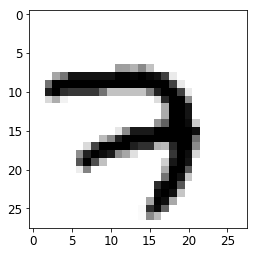

[[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.        

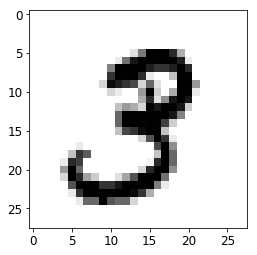

In [3]:
# List a few images and print the data to get a feel for it. 
images = 2
for i in range(images):
    #Reshape 
    x=np.reshape(X_train[i], [28, 28])
    print(x)
    plt.imshow(x, cmap=plt.get_cmap('gray_r'))
    plt.show()
#    print("Model prediction:", preds[i])

## TFLearn: Deep learning library featuring a higher-level API for TensorFlow

- TFlearn is a modular and transparent deep learning library built on top of Tensorflow. 
- It was designed to provide a higher-level API to TensorFlow in order to facilitate and speed-up experimentations
- Fully transparent and compatible with Tensorflow
- [DNN classifier](https://www.tensorflow.org/api_docs/python/tf/contrib/learn/DNNClassifier)
- `hidden_units` list of hidden units per layer. All layers are fully connected. Ex. [64, 32] means first layer has 64 nodes and second one has 32.
- [Scikit learn wrapper for TensorFlow Learn Estimator](https://www.tensorflow.org/api_docs/python/tf/contrib/learn/SKCompat)
- See [tflearn documentation](http://tflearn.org/).


In [4]:
import tensorflow as tf
config = tf.contrib.learn.RunConfig(tf_random_seed=42) # not shown in the config
feature_cols = tf.contrib.learn.infer_real_valued_columns_from_input(X_train)
# List of hidden units per layer. All layers are fully connected. Ex. [64, 32] means first layer has 64 nodes and second one has 32.
dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units=[300,100], n_classes=10,
                                         feature_columns=feature_cols, config=config)
dnn_clf = tf.contrib.learn.SKCompat(dnn_clf) # if TensorFlow >= 1.1
dnn_clf.fit(X_train, y_train, batch_size=50, steps=4000)

INFO:tensorflow:Using config: {'_task_id': 0, '_is_chief': True, '_save_checkpoints_steps': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_keep_checkpoint_max': 5, '_save_summary_steps': 100, '_master': '', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x11fc21ef0>, '_task_type': None, '_num_ps_replicas': 0, '_environment': 'local', '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_secs': 600, '_tf_random_seed': 42}


AttributeError: module 'tensorflow.contrib.learn' has no attribute 'SKCompat'

In [ ]:
#We can use the sklearn version of metrics

from sklearn import metrics
y_pred = dnn_clf.predict(X_test)
#This calculates the accuracy.
print("Accuracy score: ", metrics.accuracy_score(y_test,  y_pred['classes']) )

#Log Loss is a way of score classes probabilsitically 
print("Logloss: ",metrics.log_loss(y_test, y_pred['probabilities']))

### Tensorflow
- Direct access to Python API for Tensorflow will give more flexibility 
- Like earlier, we will define the structure and then run the session. 
- set placeholders 

In [5]:
import tensorflow as tf

n_inputs = 28*28  # MNIST
n_hidden1 = 300   # hidden units in first layer.
n_hidden2 = 100
n_outputs = 10    # Classes of output variable.

In [6]:
#Placehoder
reset_graph()
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [7]:
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

In [8]:
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1", activation=tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2", activation=tf.nn.relu)
    logits = neuron_layer(hidden2, n_outputs, name="outputs")

In [9]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [10]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [11]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [12]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

### Running the Analysis over 40 Epocs
- 40 passes through entire dataset.
- 

In [13]:
n_epochs = 40
batch_size = 50
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images,
                                            y: mnist.test.labels})
        print("Epoc:", epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_model_final.ckpt")

Epoc: 0 Train accuracy: 0.94 Test accuracy: 0.9084
Epoc: 1 Train accuracy: 0.94 Test accuracy: 0.9289
Epoc: 2 Train accuracy: 0.96 Test accuracy: 0.9401
Epoc: 3 Train accuracy: 0.94 Test accuracy: 0.946
Epoc: 4 Train accuracy: 0.96 Test accuracy: 0.9501
Epoc: 5 Train accuracy: 0.94 Test accuracy: 0.9546
Epoc: 6 Train accuracy: 0.94 Test accuracy: 0.957
Epoc: 7 Train accuracy: 0.98 Test accuracy: 0.9582
Epoc: 8 Train accuracy: 0.98 Test accuracy: 0.9613
Epoc: 9 Train accuracy: 0.96 Test accuracy: 0.9649
Epoc: 10 Train accuracy: 0.96 Test accuracy: 0.9661
Epoc: 11 Train accuracy: 0.98 Test accuracy: 0.9662
Epoc: 12 Train accuracy: 0.94 Test accuracy: 0.9679
Epoc: 13 Train accuracy: 1.0 Test accuracy: 0.9693
Epoc: 14 Train accuracy: 0.96 Test accuracy: 0.969
Epoc: 15 Train accuracy: 1.0 Test accuracy: 0.9703
Epoc: 16 Train accuracy: 1.0 Test accuracy: 0.9717
Epoc: 17 Train accuracy: 1.0 Test accuracy: 0.9718
Epoc: 18 Train accuracy: 0.98 Test accuracy: 0.9718
Epoc: 19 Train accuracy: 1.0 

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt") # or better, use save_path
    X_new_scaled = mnist.test.images[:20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)

In [ ]:
print("Predicted classes:", y_pred)
print("Actual classes:   ", mnist.test.labels[:20])

In [ ]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [ ]:
show_graph(tf.get_default_graph())

## Using `dense()` instead of `neuron_layer()`

Note: the book uses `tensorflow.contrib.layers.fully_connected()` rather than `tf.layers.dense()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.dense()`, because anything in the contrib module may change or be deleted without notice. The `dense()` function is almost identical to the `fully_connected()` function, except for a few minor differences:
* several parameters are renamed: `scope` becomes `name`, `activation_fn` becomes `activation` (and similarly the `_fn` suffix is removed from other parameters such as `normalizer_fn`), `weights_initializer` becomes `kernel_initializer`, etc.
* the default `activation` is now `None` rather than `tf.nn.relu`.
* a few more differences are presented in chapter 11.

In [ ]:
n_inputs = 28*28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [ ]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y") 

In [ ]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1",
                              activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2",
                              activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [ ]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [ ]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [ ]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [ ]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
n_epochs = 20
n_batches = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_model_final.ckpt")

In [ ]:
show_graph(tf.get_default_graph())